This notebook exists to get, from our parsed sample of Wikidata, a list of entities that belong to each of the categories (or themes) used on WebNLG, as well as to 5 more we have defined.

To do this, it follows the following steps:
1. It connects to our parsed database
2. It looks at the P31 property (non-deprecated) to see what are the largest overall categories in Wikidata to obtain the new 5 categories from. (originally, this was coded and executed before all other analysis took place, even the subtree structure calculation on `WebNLG_Classes_To_Wikidata_Mapping.ipynb`)
3. Loads the subtree structures calculated on the notebook `WebNLG_Classes_To_Wikidata_Mapping.ipynb` and flattens them for easier processing.
4. Calculates subtree overlap to see if our new classes are not overlapping the ones in WebNLG too much.
5. Calculates how many instances (through P31) and subclasses are in each theme and use that to decide how to take entities.
6. Gather final list of entities on each theme.
    1. For Food, we use the subclasses themselves, as instances of food are extremely rare and the vast majority of foods are classes.
    2. For professions, we use the occupation predicate, as there are very few instances of professions (see ontoclean).
    3. For all the rest, we use P31 as calculated in point 5 above.
7. Save this list in `final_entity_list.p`

In [230]:
import sqlite3
import numpy as np
import pandas as pd
import json
import pdb
import ast
from importlib import reload
import wikidata_utils as wdutils

# Setting up database access

In [231]:
db = sqlite3.connect('wikidata_claims_refs_parsed.db')
cursor = db.cursor()

In [232]:
claims_columns = ['entity_id','claim_id','rank','property_id','datatype','datavalue']

In [233]:
# Checking first few elements
cursor.execute('select * from claims limit 15;')
head_df = pd.DataFrame(cursor.fetchall())
head_df.columns = claims_columns
head_df

,entity_id,claim_id,rank,property_id,datatype,datavalue
0,Q23,Q23$041e45df-45c4-d094-293c-5bb349915991,preferred,P509,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
1,Q23,Q23$10f2f86e-48d5-7f87-d1f9-2209ad22b5f8,normal,P509,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
2,Q23,Q23$55314e7d-4e6e-0e48-dd5e-369b15528813,normal,P947,external-id,"{'value': '000025437', 'type': 'string'}"
3,Q23,q23$A0F25969-96F6-4354-A795-73BAD12A90D8,normal,P20,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
4,Q23,q23$8A2F4718-6159-4E58-A8F9-6F24F5EFEC42,normal,P26,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
5,Q23,q23$05CC0EC0-2078-4844-B78C-DFCD1307A630,normal,P109,commonsMedia,"{'value': 'George Washington signature.svg', '..."
6,Q23,q23$A51FED6A-DBEF-4415-B613-52753B0612BF,normal,P22,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
7,Q23,q23$DF2FAA9F-BDD0-4A08-9C20-B83FA42AADA5,normal,P25,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
8,Q23,Q23$1004C4FD-56A2-4B27-ACD7-DE8E31931083,normal,P27,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
9,Q23,Q23$f0d4604c-449d-b223-aa02-1f59f4529117,normal,P27,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."


In [6]:
# Checking total of claims
cursor.execute('select count(*) from claims')
cursor.fetchall()

[(256557241,)]

# Looking at P31 (instance of) property

https://www.wikidata.org/wiki/Help:Basic_membership_properties

In [235]:
# To extract the values from datavalue columns
def convert_datavalue(datavalue, datatype):
    try:
        if datavalue in ['novalue','somevalue']:
            return datavalue
        datavalue = ast.literal_eval(datavalue)
        if datatype == 'wikibase-item':
            return datavalue['value']['id']
        else:
            raise Exception
    except ValueError as e:
        pdb.set_trace()
        raise e

In [8]:
cursor.execute('select count(*) from claims where property_id="P31"')
cursor.fetchall()
# Number of single P31 properties in the database: 19791222

[(19791222,)]

In [9]:
cursor.execute('select claim_rank, count(claim_rank) from claims where property_id="P31" group by claim_rank')
cursor.fetchall()
# This means that 3.34% are deprecated, 96.6% are normal, and 0.07% are preferred.

[('deprecated', 661591), ('normal', 19115097), ('preferred', 14534)]

## Deprecated cases

In [10]:
# Just taking a look at the deprecated ones to see what's up
cursor.execute(
    '''
    select *
    from claims
    where property_id="P31" and claim_rank="deprecated"
    '''
)
deprecated_P31_df = pd.DataFrame(cursor.fetchall())

In [11]:
deprecated_P31_df.columns = claims_columns
deprecated_P31_df['class_entity'] = deprecated_P31_df.apply(
        lambda x : convert_datavalue(x['datavalue'], x['datatype']) , axis=1
)

In [12]:
'''
We can see that over 87% of them are just two classes: infrared source (Q67206691) and star (Q523)
The following 10 are: 
- near-IR source (Q67206785), a subclass of infrared source
- astronomical radio source (Q1931185) 
- galaxy (Q318)
- high proper-motion star (Q2247863), a subclass of star
- double star (Q13890), NOT a subclass of star  
- active galactic nucleus (Q46587), a subclass of galaxy      
- variable star (Q6243), a subclass of star      
- astrophysical X-ray source (Q2154519), NOT a subclass of infrared source 
- long period variable (Q1153690), a subclass of variable star, which is a subclass of star
- quasar (Q83373), a subclass of active galactic nucleus

This sums to 94.44% of the deprecated cases, and they are all on the domain of astronomy.
'''

deprecated_P31_df.groupby('class_entity').count().entity_id.sort_values(ascending=False).head(20)/661591*100


class_entity
Q67206691    77.155675
Q523         10.615320
Q67206785     1.788567
Q1931185      1.324988
Q318          1.090099
Q2247863      0.680481
Q13890        0.519505
Q46587        0.499402
Q6243         0.401910
Q2154519      0.373947
Q1153690      0.301546
Q83373        0.298069
Q72802727     0.295197
Q1491746      0.277362
Q71798532     0.233981
Q67201574     0.225668
Q72803622     0.221889
Q72802977     0.202996
Q67201586     0.173068
Q67206701     0.161882
Name: entity_id, dtype: float64

## All non-deprecated P31 cases

In [14]:
cursor.execute(
    '''
    select *
    from claims
    where property_id="P31" and claim_rank!="deprecated"
    '''
)
P31_df = pd.DataFrame(cursor.fetchall())
P31_df.columns = claims_columns

In [15]:
P31_df['class_entity'] = P31_df.apply(
        lambda x : convert_datavalue(x['datavalue'], x['datatype']) , axis=1
)

In [17]:
#P31_df.to_csv('P31_df.csv', index=None)

## Counting classes

In [ ]:
P31_df.read_csv('P31_df.csv')

class_entity_count = P31_df[['class_entity','entity_id']].groupby('class_entity').count()#.sort_values(ascending=False)
class_entity_count.columns = ['count']
class_entity_count = class_entity_count.sort_values(by='count', ascending=False).reset_index()

In [75]:
# Getting all classes summing up to 95% of the total amount of P31 property uses
# This is because we cant use the Wikidata API for ALL of these, so we'll only use for the most prevalent
# This also possibly cuts fringe cases and possible wrong usages of entities as classes when they should not

total_sum = class_entity_count.sum()['count']
thr = 95
for i in range(class_entity_count.shape[0]):
    partial_sum = class_entity_count.iloc[:i].sum()['count']
    if 100*partial_sum/total_sum >= thr:
        print('The %dth percentile is at the %dth row' % (thr, i))
        break

The 95th percentile is at the 572th row


In [66]:
class_entity_count_95th = class_entity_count.loc[:572]
wdAPI = wdutils.CachedWikidataAPI()

In [ ]:
class_entity_count_95th['class_entity_label'] = class_entity_count_95th['class_entity'].apply(wdAPI.get_label)

In [72]:
class_entity_count_95th.to_csv('class_entity_count_95th.csv', index=None)
# This listing was then used to decide on the most numerous classes we could use that are not in WebNLG
# We obtain their subclass structure with another notebook: WebNLG_Classes_To_Wikidata_Mapping
# This reveals to us all subclasses in the subclass tree of the classes from WebNLG and the ones selected from here

In [ ]:
class_entity_count_95th.head(15)

# Creating the mapped dataset
---
Now that we know which classes to target, and also which subclasses belong to it, we can start creating a list of entity ids that belong to those classes.

In [4]:
import json
import pandas as pd

In [5]:
P31_df = pd.read_csv('P31_df.csv')

In [6]:
class_entity_count_95th = pd.read_csv('class_entity_count_95th.csv')

In [7]:
with open('WebNLG_to_Wikidata_Subclass_Tree_Thr=1000.json','r') as f:
    subclass_mapping = json.load(f)

In [8]:
def flatten_tree(subtree, flattened_subtree=None, level=0):
    if not flattened_subtree:
        flattened_subtree = []
    if type(subtree['subclasses']) == str:
        return flattened_subtree
    
    if subtree['entity_id'] == subtree['label']:
        label = 'NO_LABEL'
    else:
        label = subtree['label']
    
    flattened_subtree.append((subtree['entity_id'],label,level))
    
    if subtree['subclasses'] is None:
        pass
    else:
        for subclass_id, subclass_tree in subtree['subclasses'].items():
            flattened_subtree = flatten_tree(subclass_tree, flattened_subtree=flattened_subtree, level=level+1)
    return flattened_subtree

In [9]:
flat_subclass_mapping = {}
for k, v in subclass_mapping.items():
    flat_subclass_mapping[k] = flatten_tree(v)
    print(
        'Parsing subclass tree of',
        v['label'],
        '('+v['entity_id']+')',
        'and found',
        len(flat_subclass_mapping[k]),
        'subclasses.'
    )

Parsing subclass tree of Airport (Q1248784) and found 26 subclasses.
Parsing subclass tree of Astronaut (Q11631) and found 42 subclasses.
Parsing subclass tree of Building (Q41176) and found 5622 subclasses.
Parsing subclass tree of City (Q515) and found 210 subclasses.
Parsing subclass tree of Comicscharacter (Q1114461) and found 17 subclasses.
Parsing subclass tree of Food (Q2095) and found 20297 subclasses.
Parsing subclass tree of Monument (Q4989906) and found 961 subclasses.
Parsing subclass tree of Sportsteam (Q12973014) and found 467 subclasses.
Parsing subclass tree of University (Q3918) and found 103 subclasses.
Parsing subclass tree of Writtenwork (Q47461344) and found 19465 subclasses.
Parsing subclass tree of Athlete (Q2066131) and found 537 subclasses.
Parsing subclass tree of Artist (Q483501) and found 1410 subclasses.
Parsing subclass tree of Celestialbody (Q6999) and found 1175 subclasses.
Parsing subclass tree of Meanoftransportation (Q334166) and found 122 subclasses.

## Calculate subclass tree overlap

In [10]:
flat_subclass_mapping.keys()

dict_keys(['Q1248784', 'Q11631', 'Q41176', 'Q515', 'Q1114461', 'Q2095', 'Q4989906', 'Q12973014', 'Q3918', 'Q47461344', 'Q2066131', 'Q483501', 'Q6999', 'Q334166', 'Q82955', 'Q16521', 'Q79007', 'Q3305213', 'Q11173', 'Q8502'])

In [11]:
import numpy as np

subclass_mapping_overlap = np.empty(shape=[len(flat_subclass_mapping),len(flat_subclass_mapping)])

In [12]:
overlaps = {}
for i, k1 in enumerate(flat_subclass_mapping.keys()):
    overlaps[k1] = {}
    for j, k2 in enumerate(flat_subclass_mapping.keys()):
        overlaps[k1][k2] = []
        total_size = len(flat_subclass_mapping[k1])
        overlap_size = 0
        k2_entity_ids = [e[0] for e in flat_subclass_mapping[k2]]
        for e in flat_subclass_mapping[k1]:
            if e[0] in k2_entity_ids:
                overlaps[k1][k2].append(e)
                overlap_size+=1
        subclass_mapping_overlap[i,j] = overlap_size/total_size

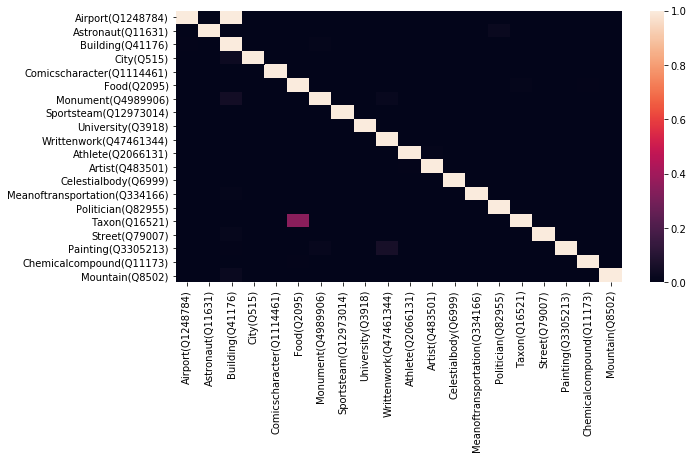

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10,5))
labels = [(v[0][1]+'('+v[0][0]+')') for k,v in flat_subclass_mapping.items()]

g = sns.heatmap(
    subclass_mapping_overlap,
    xticklabels = labels,
    yticklabels = labels,
    ax=ax
)



In [15]:
subclass_mapping_overlap[19]

array([0.        , 0.        , 0.02380952, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ])

In [14]:
overlaps.keys()

dict_keys(['Q1248784', 'Q11631', 'Q41176', 'Q515', 'Q1114461', 'Q2095', 'Q4989906', 'Q12973014', 'Q3918', 'Q47461344', 'Q2066131', 'Q483501', 'Q6999', 'Q334166', 'Q82955', 'Q16521', 'Q79007', 'Q3305213', 'Q11173', 'Q8502'])

So we see there is some overlap here:
- Airport: Seems to be pretty much contained in Building, but Building is not much present in Airport. This is reasonable, as Airports are Buildings, but not all Buildings (which has 5k subclasses compared to 26 from airport) are Airports. There is no overlap with anything else.
- Austronaut: There is a single overlap from Astronaut to Politician, which is the class 'Q4811603', 'Astronaut-Politician'
- Buildings: It has a 0.4% overlap to Airports, which makes sense. It also has a 0.1% overlap with city, as some subclasses of buildings also extend city, such as Fortified Town (Q677678). A gingerbread house is both a building and a food (sole example). Buildings also contain a few monuments (0.8% of buildings), like some forts, towers and chapels. Buildings also contain some writtenwork (0.2% of buildings), in the case writtenwork is a program like online marketplaces, which are also buildings in a sense as they are marketplaces which extend commercial building. A hotelbus is both a building and a mode of transport (sole example). Springs like onsens are both buildings and chemical compounds.
- Cities overlap minimally with buildings, as seen above.
- Comics characters have no overlap.
- Food: Pastillage is both food and monument, as it is a sugar sculpture (sole example). Things like magical frogs (due to being magic,occultism,pseudo-scholarship,writtenwork) and protein shakes (due to being a regimen,plan,writtenwork) are written work. RiceNoodleRoll and other regional dishes are also written work because at some point, it is regional cuisine which extends 'aspect in a geographical region' which is a 'Wikimedia overview article', which might be an error or something wrong with how these things are encoded. Some food is taxon, for obvious reason, 0.1%. And some food are chemical compounds, also obvious 0.4%.
- Monument: Some monuments 5% are buildings. Some are food (pastillage, see above), some are written work (like runestones and mosaics etc), 2%. And some are paintings (0.3%).
- Sportsteam has no overlap.
- University has no overlap.
- Written work has some overlap, all around 0.1% or lower.
- Athlete: overlaps a bit (1%) with artist, like ice dancers, break dancers, etc.
- Artist: overlaps with athlete (0.4%), see above.
- CelestialBody: Has a single overlap with writtenwork: TelevisionInfraredObservationSatellite, being both a satellite and a space program.
- Means of transportation: Hotelbus, a bus hotel (building).
- Politician: Some are astronauts. Some overlap with writtenwork (such as Authority, which is a huge overlap we have previously cut due to processing resources).
- Taxon is present (34%) in Food. See Food.
- Street: Cardo Q1035793 is both street and building, it seems.
- Painting: monument, building, written work (6%), see above (all between 0.5-1%).
- Chemical Compound: Building (onsens), Food (clearly, like sugars and water), written work (see above).
- Mountain: Two entities which are also buildings: 'Q1595289', 'SacredMountain' and 'Q11588709', 'Sintaisan'.

Some other overlaps were seen but very minimal, like one class overlapping two trees for very specific or very erronous reasons, like the ones seen above or like Alkaline Water, which is pseudoscience hence writtenwork, but is a chemical compound.

The overlaps seen in the list above are almost complete, and most of them are in the 0.01 - 0.5% range, with a few reaching 1%, and two reaching 5-6%. The prominent overlaps are only: Airport fully contained in Building, and Taxon slighly contained in Food.

As such, we create the following rules:
- An entity can only be a Building (Q41176) if it is not an Airport (Q1248784)
- An entity can only be a Food (Q2095) if it is not a Taxon (Q16521).

The remaining overlaps do not matter much.
The overlapping between Taxon and Food is slight, but we do not worry about it since non-Food taxons tend to be only living being species with a tendency to have specific types of claims, like taxon rank, taxon parent, taxon common name, conservation status, life expectancy, gestation period, mass, etc.

 

## Class lookup function

In [36]:
flat_subclass_mapping.keys()

dict_keys(['Q1248784', 'Q11631', 'Q41176', 'Q515', 'Q1114461', 'Q2095', 'Q4989906', 'Q12973014', 'Q3918', 'Q47461344', 'Q2066131', 'Q483501', 'Q6999', 'Q334166', 'Q82955', 'Q16521', 'Q79007', 'Q3305213', 'Q11173', 'Q8502'])

In [189]:
def get_subclass_root(entity_id, flat_subclass_mapping=flat_subclass_mapping, at_level=None):
    try:
        #pdb.set_trace()
        overlapping_cases = {'Q41176':False,'Q1248784':False,'Q2095':False,'Q16521':False}
        for k in flat_subclass_mapping.keys():
            if at_level:
                subclasses_entity_ids = [e[0] for e in flat_subclass_mapping[k] if e[2] == at_level[k]]
            else:
                subclasses_entity_ids = [e[0] for e in flat_subclass_mapping[k]]
            if entity_id in subclasses_entity_ids:
                if k not in overlapping_cases.keys():
                    return k
                else:
                    overlapping_cases[k] = True

        if overlapping_cases['Q41176'] or overlapping_cases['Q1248784']:
            if overlapping_cases['Q1248784']: #Airport
                return 'Q1248784' #Airport
            else:
                return 'Q41176'#Building

        if overlapping_cases['Q2095'] or overlapping_cases['Q16521']:
            if overlapping_cases['Q16521']: #Taxon
                return 'Q16521' #Taxon
            else:
                return 'Q2095'#Food

        return 'NONE'
    except ValueError as e:
        return 'ERROR: '+str(e)

In [ ]:
from collections import Counter
for k in flat_subclass_mapping.keys():
    print(flat_subclass_mapping[k][0])
    print(Counter(map(
        lambda x: get_subclass_root(x, flat_subclass_mapping),
        [e[0] for e in flat_subclass_mapping[k]]
    )))
    print()

## Getting list of entities in such themes

Here, we see how many entities actually are **instance of** any subclass in the subclass tree for the root classes listed here. 

In [ ]:
# Import
from pandarallel import pandarallel

# Initialization
pandarallel.initialize(progress_bar=True)

In [ ]:
P31_df['root_class'] = P31_df.class_entity.parallel_apply(lambda x : get_subclass_root(x, flat_subclass_mapping))

In [66]:
P31_df.to_csv('P31_df.csv', index=None)

### Analysing the amounts of entities obtained through subclass trees
Specially compared to the sizes and depths of each subclass tree.
We look for instances per subclass tree size, and also the number of subclasses in the last level compared to all levels.

**NOTE: ALL THE ENTITY COUNTS HERE ARE BASED ON OUR 20% SAMPLE FROM WIKIDATA, NOT ON THE WHOLE THING**

In [157]:
import wikidata_utils as wdutils
import seaborn as sns
wdAPI = wdutils.CachedWikidataAPI()
import matplotlib.pyplot as plt

In [166]:
root_class_counter = {}
for k in flat_subclass_mapping.keys():
    P31_df_k = P31_df[P31_df.root_class == k]
    root_class_counter[k] =  len(P31_df_k.entity_id.unique())   

In [311]:
subclass_instance_rate = []
for k,v in root_class_counter.items():
    if k == 'NONE':
        continue
    print(
        flat_subclass_mapping[k][0][1],
        'has', len(flat_subclass_mapping[k]),'subclasses in its tree and',
        root_class_counter[k], 'entities in total. This makes',
        round(root_class_counter[k]/len(flat_subclass_mapping[k]),2),'instances per subclass.\n'
    )
    subclass_instance_rate.append({
        'name': flat_subclass_mapping[k][0][1] + '(' + k + ')',
        'n_entities': root_class_counter[k],
        'n_subclasses': len(flat_subclass_mapping[k]),
        'subclass_entity_ratio': round(root_class_counter[k]/len(flat_subclass_mapping[k]),2)
    })

Airport has 26 subclasses in its tree and 4982 entities in total. This makes 191.62 instances per subclass.

Astronaut has 42 subclasses in its tree and 4 entities in total. This makes 0.1 instances per subclass.

Building has 5622 subclasses in its tree and 379879 entities in total. This makes 67.57 instances per subclass.

City has 210 subclasses in its tree and 5632 entities in total. This makes 26.82 instances per subclass.

Comicscharacter has 17 subclasses in its tree and 1913 entities in total. This makes 112.53 instances per subclass.

Food has 20297 subclasses in its tree and 2693 entities in total. This makes 0.13 instances per subclass.

Monument has 961 subclasses in its tree and 73057 entities in total. This makes 76.02 instances per subclass.

Sportsteam has 467 subclasses in its tree and 10859 entities in total. This makes 23.25 instances per subclass.

University has 103 subclasses in its tree and 3355 entities in total. This makes 32.57 instances per subclass.

Written

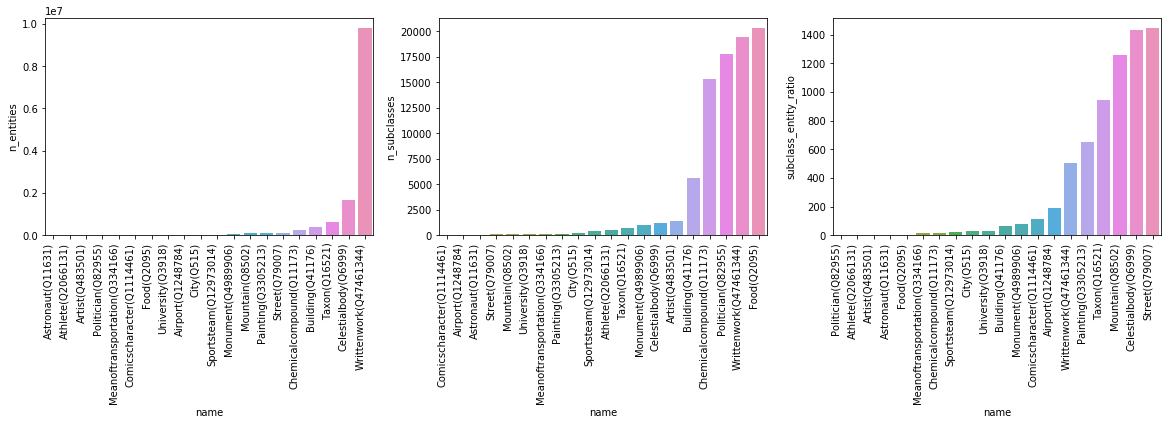

In [216]:
fig, ax = plt.subplots(1,3,figsize=(20,4))

subclass_instance_rate_df = pd.DataFrame(subclass_instance_rate)
g = sns.barplot(
    data=subclass_instance_rate_df.sort_values('n_entities'),
    x='name',
    y ='n_entities',
    ax=ax[0]
)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha='right')

g = sns.barplot(
    data=subclass_instance_rate_df.sort_values('n_subclasses'),
    x='name',
    y ='n_subclasses',
    ax=ax[1]
)

ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, ha='right')

g = sns.barplot(
    data=subclass_instance_rate_df.sort_values('subclass_entity_ratio'),
    x='name',
    y ='subclass_entity_ratio',
    ax=ax[2]
)

ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=90, ha='right')

plt.show()

In [229]:
max_levels = {k:max([i[2] for i in v]) for k,v in flat_subclass_mapping.items()}
max_levels

{'Q1248784': 2,
 'Q11631': 2,
 'Q41176': 9,
 'Q515': 5,
 'Q1114461': 2,
 'Q2095': 10,
 'Q4989906': 7,
 'Q12973014': 5,
 'Q3918': 3,
 'Q47461344': 17,
 'Q2066131': 5,
 'Q483501': 7,
 'Q6999': 6,
 'Q334166': 5,
 'Q82955': 8,
 'Q16521': 5,
 'Q79007': 3,
 'Q3305213': 4,
 'Q11173': 13,
 'Q8502': 3}

### Resolving the issue of low-entity themes

- Celestialbody has 1175 subclasses in its tree and 1691976 entities in total. This makes 1439.98 instances per subclass.

- City has 210 subclasses in its tree and 6650 entities in total. This makes 31.67 instances per subclass.

- Building has 5622 subclasses in its tree and 403263 entities in total. This makes 71.73 instances per subclass.

- Writtenwork has 19465 subclasses in its tree and 10412520 entities in total. This makes 534.94 instances per subclass.

- Sportsteam has 467 subclasses in its tree and 11171 entities in total. This makes 23.92 instances per subclass.

- University has 103 subclasses in its tree and 3503 entities in total. This makes 34.01 instances per subclass.

- Taxon has 680 subclasses in its tree and 664731 entities in total. This makes 977.55 instances per subclass.

- Food has 20297 subclasses in its tree and 2880 entities in total. This makes **0.14** instances per subclass.

- Street has 81 subclasses in its tree and 117467 entities in total. This makes 1450.21 instances per subclass.

- Airport has 26 subclasses in its tree and 5171 entities in total. This makes 198.88 instances per subclass.

- Mountain has 84 subclasses in its tree and 105767 entities in total. This makes 1259.13 instances per subclass.

- Chemicalcompound has 15324 subclasses in its tree and 267865 entities in total. This makes 17.48 instances per subclass.

- Painting has 169 subclasses in its tree and 109732 entities in total. This makes 649.3 instances per subclass.

- Comicscharacter has 17 subclasses in its tree and 1964 entities in total. This makes 115.53 instances per subclass.

- Monument has 961 subclasses in its tree and 75408 entities in total. This makes 78.47 instances per subclass.

- Meanoftransportation has 122 subclasses in its tree and 1666 entities in total. This makes 13.66 instances per subclass.

- Artist has 1410 subclasses in its tree and 72 entities in total. This makes **0.05** instances per subclass.

- Politician has 17778 subclasses in its tree and 223 entities in total. This makes **0.01** instances per subclass.

- Athlete has 537 subclasses in its tree and 10 entities in total. This makes **0.02** instances per subclass.

- Astronaut has 42 subclasses in its tree and 4 entities in total. This makes **0.1** instances per subclass.

**NOTE: ALL THE ENTITY COUNTS HERE ARE BASED ON OUR 20% SAMPLE FROM WIKIDATA, NOT ON THE WHOLE THING**

This tells us that for some classes, namely Food, Artist, Politician, Athlete and Astronaut, looking at instance-of (P31) will not be a good way to gather entities from those themes.

Excluding them, the minimum amount of entities we find is 1666, which sets the lowest number of entities (and if we manage to take one claim per entity, of claims) that we can find per theme. Including them, this goes down to a whopping 4.

For the Food class, we know the issue is with not many instances of food existing, which means we will have to **take information from the classes** in the tree. This approach could also be taken with Taxon entities, but most Taxons either just instance Taxon or both instance **and** extend Taxon (are both an instance and a subclass, like Hebra Q30132039). This means that, for Food, we go from the 2880 instances to the 20297 classes as potental sources of claim information.

For the Artist, Politician, Athlete and Astronaut classes, and in accordance to Ontoclean, it makes sense for entities to not instanciate these classes, but to refer to it through qualified predicates. This is because a politician is not intrinsically a politician, but a person who happens to be occupied in a politician position (which might be temporary, hence the need for qualifiers). So we will look for these through the occupation/profession predicates. For this, we will **look for entities whose occupation (P106) predicates link to one of the subclasses in this tree**. 

#### Professions/Occupations

In [236]:
cursor.execute(
    '''
    select *
    from claims
    where property_id="P106" and claim_rank!="deprecated"
    '''
)
P106_df = pd.DataFrame(cursor.fetchall())
P106_df.columns = claims_columns

In [238]:
P106_df['object_entity'] = P106_df.apply(
        lambda x : convert_datavalue(x['datavalue'], x['datatype']) , axis=1
)

In [239]:
P106_df

,entity_id,claim_id,rank,property_id,datatype,datavalue,object_entity
0,Q23,q23$7F1176DF-B1EF-4B9D-9249-993D14D9AC4D,preferred,P106,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",Q82955
1,Q23,q23$212B925B-881F-4778-A2B5-302C9FBD9A41,normal,P106,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",Q189290
2,Q23,Q23$7891ba2b-454a-b218-e48c-f08f1f8ce76d,normal,P106,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",Q131512
3,Q23,Q23$3AE23BD2-7CDE-4B11-99D3-FA7133DE422D,normal,P106,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",Q1734662
4,Q23,Q23$4240dd5c-4f0a-4763-01e9-60179aed55fe,normal,P106,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",Q294126
...,...,...,...,...,...,...,...
1700597,Q107161748,Q107161748$3BC85D63-5295-4F2B-AA72-C4FEC10580FF,normal,P106,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",Q82955
1700598,Q107161748,Q107161748$f708baef-4c9a-8bf6-4e93-12e4f18dccd8,normal,P106,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",Q3315492
1700599,Q107161750,Q107161750$7086DA9F-9A4F-46D2-957C-C615FB33BCC9,normal,P106,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",Q82955
1700600,Q107161753,Q107161753$30C71055-594D-4D57-8074-FD07026DE6DA,normal,P106,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",Q82955


In [290]:
profession_themes = ['Q11631', 'Q2066131', 'Q483501', 'Q82955']

# Total in our sample:
in_profession_entities = {}
for profession in profession_themes:
    in_profession_entities[profession] = set()
    #print('Gathering',flat_subclass_mapping[profession][0][1],'profession.')
    for subclass in flat_subclass_mapping[profession]:
        subclass_id = subclass[0]
        in_profession_entities[profession].update(P106_df[P106_df.object_entity == subclass_id].entity_id)
    print(
        'Theme',
        flat_subclass_mapping[profession][0][1],
        'has number of entities:',
        len(in_profession_entities[profession])
    )


Theme Astronaut has number of entities: 190
Theme Athlete has number of entities: 207422
Theme Artist has number of entities: 248648
Theme Politician has number of entities: 141497


In [250]:
import pickle
with open('in_profession_entities.p','wb') as f:
    pickle.dump(in_profession_entities, f)

This increases our Astronaut count from 4 to 190 (which is 20% of the over 870 in Wikidata). It makes sense for this to be a more restricted group. We then have many more Athletes (207422 against 10), Artists (248648 against 72) and Politician (141497 against 223). It would be interesting to know what types of entities we got from the instance-of route, and see if they can be used as in addition to these from the occupation route.

In [282]:
import random
random.seed(42)
for profession in profession_themes:
    print('Samples from',flat_subclass_mapping[profession][0][1],'using instance-of route:')
    sample_from = P31_df[P31_df.root_class == profession].entity_id
    print(sample_from.sample(min(10,sample_from.shape[0])).values)

Samples from Astronaut using instance-of route:
['Q210184' 'Q98859881' 'Q49819' 'Q17189861']
Samples from Athlete using instance-of route:
['Q97681048' 'Q97680424' 'Q86919324' 'Q97680380' 'Q65467391' 'Q106978684'
 'Q97680788' 'Q11442596' 'Q65467154' 'Q60649957']
Samples from Artist using instance-of route:
['Q64759358' 'Q104787869' 'Q106419065' 'Q85961988' 'Q11224956' 'Q6785309'
 'Q60152537' 'Q106712985' 'Q105089922' 'Q105722121']
Samples from Politician using instance-of route:
['Q5781602' 'Q703390' 'Q11929798' 'Q20018881' 'Q24942143' 'Q5782255'
 'Q5781888' 'Q100271063' 'Q56101828' 'Q5781371']


For Astronaut:

    We look at all 4 entities. They either also have Astronaut as occupation or are fictional characters.
    
For Athlete:

    We looked at all 10 entities. 4 of them are sailors (sailing) with only a single label in Spanish and a Google Knowledge Graph ID predicate, and 2 martial artists with very few labels and the same GKG ID, which seems to indicate niche utilisation by some project. Others were either very specific entities (like two horsemen of the apocalypse) or just entities which directly instance an athlete profession but have very few other claims.  

For Artist:
    
    We sampled 10 entities from 72. 2 of them both instantiate AND have profession to an artist subclass. 1 of them is an anonymous pseudonym which is a subclass of artist, but does not have occupation because it is not a person per se. 3 were entities with very few labels, instance of an astist subclass, and none to almost none claims. The rest were entities making wrong use of artist subclasses. 1 was a musical group, which makes sense. 2 were video game developer studios, whose position in Artist is somewhat disputable for the meaning of artist we are after (a single game developer would be ok, but a studio is a company).
    
For Politician:

    We sampled 10 entities from 223. 9 were entities with very few labels and none to almost no claims apart from GKG ID or Freebase ID, 5 of which were condes in Spain. 1 had both instance of and occupation.
    
The quality of these examples, compared to the amount of entities we were able to obtain through the occupation route, leads us to believe it would be preferrable to take only from the occupation route.

### Getting final list of entities in each theme

- For non-food and non-profession themes, we will obtain through P31 root class.
- For the food theme, we will obtain through the subclass tree itself.
- For the profession themes, we will obtain through the occupation predicate.

In [298]:
final_entity_list = {}

In [300]:
# NON-FOOD AND NON-PROFESSION THEMES
P31_themes = ['Q1248784', 'Q41176', 'Q515', 'Q1114461', 'Q4989906', 'Q12973014',
              'Q3918', 'Q47461344', 'Q6999', 'Q334166', 'Q16521',
              'Q79007', 'Q3305213', 'Q11173', 'Q8502']

for theme in P31_themes:
    print('Loading',flat_subclass_mapping[theme][0][1],'theme.')
    final_entity_list[theme] = set()
    final_entity_list[theme].update(P31_df[P31_df.root_class == theme].entity_id.values)

Loading Airport theme.
Loading Building theme.
Loading City theme.
Loading Comicscharacter theme.
Loading Monument theme.
Loading Sportsteam theme.
Loading University theme.
Loading Writtenwork theme.
Loading Celestialbody theme.
Loading Meanoftransportation theme.
Loading Taxon theme.
Loading Street theme.
Loading Painting theme.
Loading Chemicalcompound theme.
Loading Mountain theme.


In [303]:
# PROFESSION THEMES
for theme in profession_themes:
    final_entity_list[theme] = in_profession_entities[theme]

In [307]:
# FOOD THEME
final_entity_list['Q2095'] = set()
final_entity_list['Q2095'].update([e[0] for e in flat_subclass_mapping['Q2095']])

In [312]:
for theme in flat_subclass_mapping:
    print('Theme',flat_subclass_mapping[theme][0][1], 'has', len(final_entity_list[theme]), 'entities.')
    
with open('final_entity_list.p','wb') as f:
    pickle.dump(final_entity_list, f)

Theme Airport has 4982 entities.
Theme Astronaut has 190 entities.
Theme Building has 379879 entities.
Theme City has 5632 entities.
Theme Comicscharacter has 1913 entities.
Theme Food has 20297 entities.
Theme Monument has 73057 entities.
Theme Sportsteam has 10859 entities.
Theme University has 3355 entities.
Theme Writtenwork has 9797724 entities.
Theme Athlete has 207422 entities.
Theme Artist has 248648 entities.
Theme Celestialbody has 1682609 entities.
Theme Meanoftransportation has 1665 entities.
Theme Politician has 141497 entities.
Theme Taxon has 640050 entities.
Theme Street has 117003 entities.
Theme Painting has 109460 entities.
Theme Chemicalcompound has 265464 entities.
Theme Mountain has 105615 entities.
